# Estratégias de Sampling para Modelos de Classificação Imbalanceados

Este notebook demonstra o uso de diferentes estratégias de sampling (Undersampling, SMOTE e Cost-Sensitive Learning) para lidar com datasets desbalanceados em problemas de classificação. Ele é projetado para ser um template, permitindo a fácil troca do modelo de classificação a ser avaliado.

**Modelo Inicial:** Regressão Logística
**Métricas de Avaliação:** F1-score, Precisão Média (Average Precision) e Curva Precision-Recall.

In [1]:
import importlib, subprocess, sys

def install_if_missing(pkg, import_name=None):
    try:
        importlib.import_module(import_name or pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

for pkg, imp in [
    ("seaborn", None),
    ("graphviz", None),
    ("imbalanced-learn", "imblearn"),
    ("xgboost", None),
]:
    install_if_missing(pkg, imp)


In [ ]:

# 1. Importar Bibliotecas Necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

from pathlib import Path

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, average_precision_score, precision_recall_curve, PrecisionRecallDisplay

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Baixar funções compartilhadas, se necessário
if not os.path.exists('shared_functions.py'):
    import urllib.request
    urllib.request.urlretrieve(
        'https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py',
        'shared_functions.py'
    )


# Baixar dados simulados, se necessário
if not os.path.exists('simulated-data-transformed'):
    os.system('git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed')

from shared_functions import *

# Carregar funções compartilhadas e dados reais, conforme Anomaly.ipynb
import os
import datetime

import warnings
warnings.filterwarnings('ignore')

## 2. Geração de Dados Sintéticos (Exemplo)

Para fins de demonstração, vamos gerar um dataset sintético desbalanceado. Em um cenário real, você carregaria seu próprio dataset.

In [23]:

project_root = Path().resolve()
DIR_INPUT = project_root / 'simulated-data-transformed' / 'data'
BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"
# git lfs pull

print("Load files")
transactions_df = read_from_files(str(DIR_INPUT), BEGIN_DATE, END_DATE)
print(f"{len(transactions_df)} transactions loaded, containing {transactions_df.TX_FRAUD.sum()} fraudulent transactions")

output_feature = "TX_FRAUD"
input_features = [
    'TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
    'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
    'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
    'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
    'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
    'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
    'TERMINAL_ID_RISK_30DAY_WINDOW'
]

# Separar treino e teste conforme o handbook
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = 7
delta_delay = 7
delta_test = 7
delta_valid = delta_test
start_date_training_with_valid = start_date_training + datetime.timedelta(days=-(delta_delay+delta_valid))
train_df, valid_df = get_train_test_set(transactions_df, start_date_training_with_valid, delta_train=delta_train, delta_delay=delta_delay, delta_test=delta_test)

# Escalar os dados
train_df, valid_df = scaleData(train_df, valid_df, input_features)

X_train = train_df[input_features].values
X_test = valid_df[input_features].values
y_train = train_df[output_feature].values
y_test = valid_df[output_feature].values

print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de y_train: {y_train.shape}")
print(f"Distribuição das classes em y_train: {pd.Series(y_train).value_counts()}")

Load files
919767 transactions loaded, containing 8195 fraudulent transactions
Shape de X_train: (66928, 15)
Shape de y_train: (66928,)
Distribuição das classes em y_train: 0    66295
1      633
Name: count, dtype: int64


## 3. Função de Avaliação do Modelo

Esta função encapsula o treinamento e a avaliação do modelo, facilitando a comparação entre as diferentes estratégias de sampling. Ela aceita um modelo e, opcionalmente, um pipeline de pré-processamento/sampling.

In [24]:
def evaluate_model(model, X_train, y_train, X_test, y_test, strategy_name="Baseline"):
    """
    Treina e avalia um modelo de classificação usando as métricas especificadas.
    """
    print(f"\n--- Avaliando: {strategy_name} ---")

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Previsões
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Calcular métricas
    f1 = f1_score(y_test, y_pred)
    avg_precision = average_precision_score(y_test, y_proba)

    print(f"F1-score: {f1:.4f}")
    print(f"Precisão Média (Average Precision): {avg_precision:.4f}")

    # Plotar Curva Precision-Recall
    display = PrecisionRecallDisplay.from_estimator(
        model, X_test, y_test, name=strategy_name
    )
    _ = display.ax_.set_title(f"Curva Precision-Recall: {strategy_name}")
    plt.show()

    return {
        'strategy': strategy_name,
        'f1_score': f1,
        'average_precision': avg_precision
    }

## 4. Tuning de Hiperparâmetros para Técnicas de Balanceamento

Nesta seção definimos um pipeline genérico que integra o sampling e o classificador, e em seguida exploramos de forma sistemática três estratégias de balanceamento de classes (undersampling, oversampling e SMOTE). Para cada técnica, montamos uma grade de hiperparâmetros e realizamos uma busca cruzada estratificada (3 folds) usando a métrica Average Precision. Por fim, extraímos o melhor pipeline de cada abordagem (best_under_pipe, best_over_pipe, best_smote_pipe) para uso nas etapas de avaliação e comparação.

In [ ]:
base_pipe = Pipeline(steps=[
    ("sampler", RandomUnderSampler()),             # substituído pelo Grid
    ("clf"    , LogisticRegression(
                    solver="liblinear",
                    random_state=42)),
])

param_grid_under = {
    "sampler"                 : [RandomUnderSampler()],
    "sampler__sampling_strategy": [0.05, 0.10, 0.25, 0.50],  # mantém, após remover exemplos da classe majoritária, de 5 % até 50 % do tamanho original dessa classe.
    "clf__C"                   : [0.01, 0.1, 1, 10],         # parâmetro de regularização do LogisticRegression (inverso da força da penalidade)
    "clf__class_weight"        : [None, "balanced"],         # dar peso igual a todas as instâncias (None) ou pesar inversamente à frequência de cada classe (“balanced”)
}

param_grid_smote = {
    "sampler"                 : [SMOTE()],
    "sampler__sampling_strategy": [0.25, 0.50, 0.75, 1.00],
    "sampler__k_neighbors"    : [3, 5, 7],                   # número de vizinhos usados pelo SMOTE para interpolar novos pontos
    "clf__C"                  : [0.01, 0.1, 1, 10],
    "clf__class_weight"       : [None, "balanced"],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

def tune_pipeline(param_grid, name):
    grid = GridSearchCV(
        estimator=base_pipe,
        param_grid=param_grid,
        scoring= "average_precision",   # usa AP para selecionar
        cv=cv,
        n_jobs=-1,
        verbose=1,
    )
    grid.fit(X_train, y_train)
    print(f"\nMelhores parâmetros para {name}:")
    for k, v in grid.best_params_.items():
        print(f"  {k:>25} : {v}")
    print(f"Average Precision (CV) : {grid.best_score_:.4f}")
    return grid.best_estimator_


## 4. Configuração do Modelo Base

Aqui definimos o modelo de classificação que será usado. Para este exemplo, começaremos com a Regressão Logística.

In [40]:
# --- TEMPLATE: Troque o modelo aqui ---
baseline = LogisticRegression(random_state=42, solver='liblinear') # 'liblinear' é bom para datasets pequenos e l1/l2 penalidades
# --------------------------------------

## 5. Avaliação das Estratégias de Sampling

### 5.1. Baseline (Sem Sampling)

Primeiro, avaliamos o modelo sem aplicar nenhuma estratégia de sampling para ter uma base de comparação.


--- Avaliando: Baseline ---
F1-score: 0.6065
Precisão Média (Average Precision): 0.5959


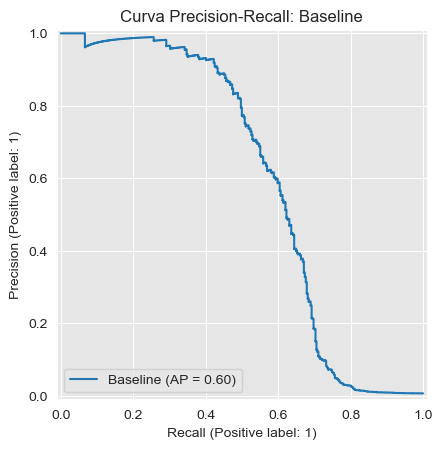

In [41]:
results = []
results.append(evaluate_model(baseline, X_train, y_train, X_test, y_test,
                              strategy_name="Baseline"))

### 5.2. Undersampling (RandomUnderSampler) otimizado

Reduz o número de amostras da classe majoritária para balancear o dataset.

Fitting 3 folds for each of 32 candidates, totalling 96 fits

Melhores parâmetros para Undersampling:
                     clf__C : 10
          clf__class_weight : None
                    sampler : RandomUnderSampler()
  sampler__sampling_strategy : 0.05
Average Precision (CV) : 0.6497

--- Avaliando: Undersampling (tuned) ---
F1-score: 0.5819
Precisão Média (Average Precision): 0.5714


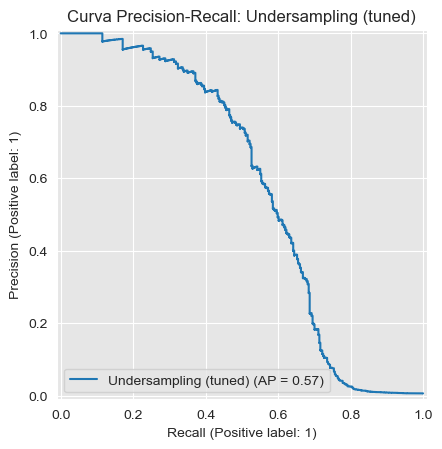

In [42]:
best_under_pipe = tune_pipeline(param_grid_under, "Undersampling")

results.append(evaluate_model(best_under_pipe, X_train, y_train, X_test, y_test,
                              strategy_name="Undersampling (tuned)"))

### 5.3. Oversampling (SMOTE) otimizado

Sintetiza novas amostras da classe minoritária para balancear o dataset.

Fitting 3 folds for each of 96 candidates, totalling 288 fits

Melhores parâmetros para SMOTE:
                     clf__C : 10
          clf__class_weight : None
                    sampler : SMOTE()
       sampler__k_neighbors : 7
  sampler__sampling_strategy : 0.25
Average Precision (CV) : 0.6001

--- Avaliando: SMOTE (tuned) ---
F1-score: 0.4736
Precisão Média (Average Precision): 0.5286


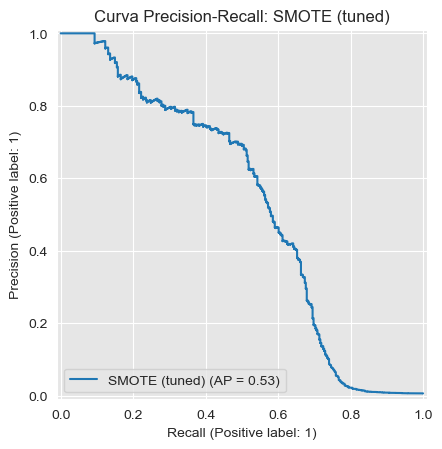

In [43]:
best_smote_pipe = tune_pipeline(param_grid_smote, "SMOTE")

results.append(evaluate_model(best_smote_pipe, X_train, y_train, X_test, y_test,
                              strategy_name="SMOTE (tuned)"))

### 5.4. Cost-Sensitive Learning (Ajuste de `class_weight`)

Em vez de reamostrar os dados, esta abordagem atribui pesos diferentes às classes durante o treinamento, penalizando mais os erros na classe minoritária. Muitos modelos do scikit-learn (como `LogisticRegression`, `SVC`, `RandomForestClassifier`) possuem o parâmetro `class_weight`.


--- Avaliando: Cost-Sensitive ---
F1-score: 0.1833
Precisão Média (Average Precision): 0.4561


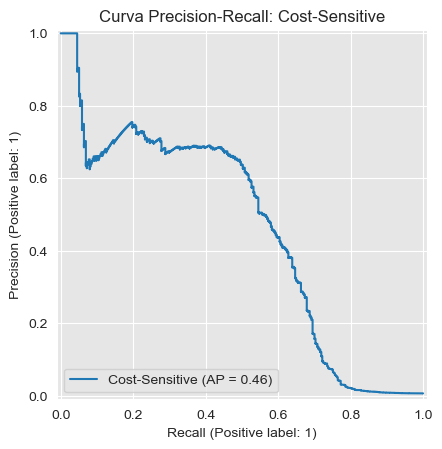

In [44]:
cost_sensitive_model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced') # Criar uma nova instância do modelo com class_weight='balanced'

results.append(evaluate_model(cost_sensitive_model, X_train, y_train, X_test, y_test, strategy_name="Cost-Sensitive"))

## 6. Comparação dos Resultados

Vamos consolidar e exibir os resultados de todas as estratégias para uma comparação fácil.


--- Comparação de Resultados ---
                       f1_score  average_precision
strategy                                          
Baseline               0.606474           0.595880
Undersampling (tuned)  0.581921           0.571360
SMOTE (tuned)          0.473634           0.528557
Cost-Sensitive         0.183299           0.456095


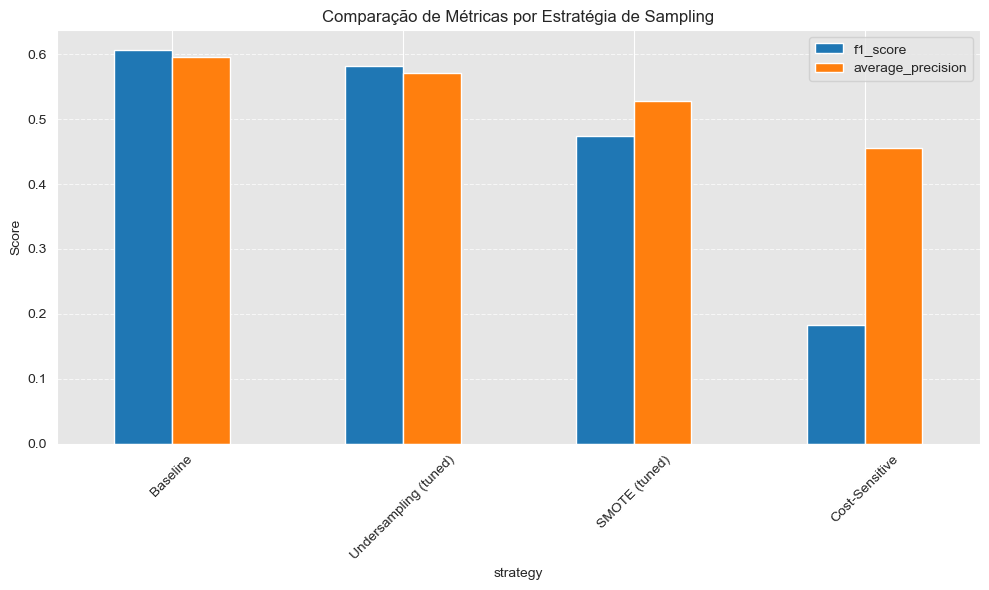

In [45]:
results_df = pd.DataFrame(results)
print("\n--- Comparação de Resultados ---")
print(results_df.set_index('strategy'))

# Opcional: Visualização dos resultados
results_df.set_index('strategy').plot(kind='bar', figsize=(10, 6))
plt.title('Comparação de Métricas por Estratégia de Sampling')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 7. Como Trocar o Modelo

Para usar um modelo diferente (ex: `RandomForestClassifier`, `SVC`, `GradientBoostingClassifier`):

1.  **Importe o novo modelo** na seção de importações.
2.  **Modifique a variável `base_model`** na seção "Configuração do Modelo Base" para instanciar o novo modelo. Certifique-se de passar `random_state` se o modelo o suportar para reprodutibilidade.
    ```python
    # Exemplo para RandomForestClassifier
    from sklearn.ensemble import RandomForestClassifier
    base_model = RandomForestClassifier(random_state=42)
    ```
3.  **Para modelos que não suportam `class_weight`** (como alguns modelos baseados em árvores que não têm um `class_weight` direto no construtor, mas podem ter outras formas de lidar com desbalanceamento), você precisará ajustar a seção "Cost-Sensitive Learning" ou remover essa estratégia se não for aplicável.
4.  **Execute todas as células** novamente para ver os resultados com o novo modelo.